In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as tt
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class Generator(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    # Encoder
    self.conv_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
    )
    self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
    )
    self.conv_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
    )
    self.conv_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
    )
    self.conv_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
    )
    self.conv_6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
    )
    self.conv_7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
    )
    self.conv_8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
    )

    # Decoder
    self.up_conv_8 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout2d(),
            nn.ReLU()
    )
    self.up_conv_7 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout2d(),
            nn.ReLU()
    )
    self.up_conv_6 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout2d(),
            nn.ReLU()
    )
    self.up_conv_5 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
    )
    self.up_conv_4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
    )
    self.up_conv_3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
    )
    self.up_conv_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
    )
    self.up_conv_1 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
    )

  def forward(self, x):
    x1 = self.conv_1(x)
    x2 = self.conv_2(x1)
    x3 = self.conv_3(x2)
    x4 = self.conv_4(x3)
    x5 = self.conv_5(x4)
    x6 = self.conv_6(x5)
    x7 = self.conv_7(x6)
    x = self.conv_8(x7)
    
    x = self.up_conv_8(x)
    x = self.up_conv_7(torch.cat((x7, x), dim=1))
    x = self.up_conv_6(torch.cat((x6, x), dim=1))
    x = self.up_conv_5(torch.cat((x5, x), dim=1))
    x = self.up_conv_4(torch.cat((x4, x), dim=1))
    x = self.up_conv_3(torch.cat((x3, x), dim=1))
    x = self.up_conv_2(torch.cat((x2, x), dim=1))
    x = self.up_conv_1(torch.cat((x1, x), dim=1))

    return x

**Код рисования изображения (следующая ячейка) взят из https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca**

In [5]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>

<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.fillRect(0, 0, 256, 256);
ctx.clearRect(1,1,254,254);
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""
def draw(filename='drawing.png', line_width=1):
  w=256
  h=256
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

**Код конвертации из RGBA to RGB (след. ячейка) взят из https://stackoverflow.com/questions/9166400/convert-rgba-png-to-rgb-with-pil**

In [6]:
def convert(image, color=(255, 255, 255)):
    """Alpha composite an RGBA Image with a specified color.

    Simpler, faster version than the solutions above.

    Source: http://stackoverflow.com/a/9459208/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    from PIL import Image
    
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background

In [7]:
def visualize_image(img):
  """
  Простая функция для визуализации одной картинки.
  
  Parameters
  ----------
  img: torch.Tenzor[3, imgsize, imgsize]

  """
  img = np.rollaxis(img.cpu().detach().numpy(), 0, 3)
  
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()

In [10]:
def draw_and_show_result():
  from PIL import Image

  draw(filename='tmp')
  img = tt.ToTensor()(convert(Image.open('tmp'))).reshape(1, 3, 256, 256)
  
  generator = torch.load(GEN_PATH, map_location=torch.device(device))
  img = generator(img.to(device))
  visualize_image(img[0])
  !rm tmp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


**Определите путь до весов генератора, переопределив переменную GEN_PATH**

In [3]:
GEN_PATH = '/content/gdrive/MyDrive/DLS/project/gen'

**Вызовите функцию draw_and_show_result, нарисуйте сапог в черной рамке, а затем нажмите кнопку finish в нижнем правом углу. Это можно проделать на  cpu в том числе, считается довольно быстро ~ 10 сек**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


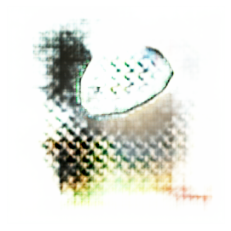

In [12]:
draw_and_show_result()